In [115]:
!pwd

/abhishek/anish/ViT_clf


In [7]:
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification, ViTConfig
from PIL import Image
import requests

In [28]:
import os
import re
import numpy as np
import pandas as pd
import cv2

# pytorch related imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
#from torchvision.datasets import CIFAR10
#from torchvision import transforms
from torchvision import transforms

from torchmetrics.functional import fbeta

# lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# sklearn related imports
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

import sys
sys.path.append("./ViT-pytorch/")
from models.modeling import VisionTransformer, CONFIGS

In [9]:
tmp_global = None

# Creating Dataset class

In [25]:
class firesmoke_image_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file_path, class_list, image_dir, filename_col_name='image_name', transform=None):
        self.filename = filename_col_name
        self.class_list = class_list
        self.class_list.sort()
        self.data_frame = pd.read_csv(csv_file_path)
        self.image_dir = image_dir
        self.transform = transform
        self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        
    def __len__(self):
        return len(self.data_frame)
        pass
    
    def __getitem__(self, index):
        
        row = self.data_frame.iloc[index]
        image_path = self.image_dir+"/"+row[self.filename].strip()
        
        img = cv2.imread(image_path)
        if img is None:
            print(f"no image found @ {image_path}")
            img = np.zeros((224,224, 3))
       
        if self.transform:
            img = self.transform(img)
            
        #img = np.einsum("ijk->kij", img)
        img = self.feature_extractor(img)['pixel_values'][0] # Don't forget this to apply while inference
        #img = image = Image.open(image_path)
        
        labels = []
        for cls in self.class_list:
            labels.append(int(row[cls]))#.to_numpy(dtype=np.float32)
        labels = np.array(labels)
        
        
            
        return [img, labels]

## test

In [26]:
dataset = firesmoke_image_dataset(csv_file_path="./raw_data/fire&safety&smoke_processed.csv",
                                  class_list=['fire', 'spark', 'smoke'],
                                  image_dir="../fnS_images/",
                                  filename_col_name="Filename")
dl = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

b = None
for batch in dl:
    b = batch
    break

In [12]:
len(dl)

213

In [29]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.CenterCrop((100, 100)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor()
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

## creating pl datamodule

In [36]:
class FireSmokeDataModule(pl.LightningDataModule):
    def __init__(self, csv_file_path, 
                 class_list, 
                 image_dir, 
                 filename_col_name='image_name', 
                 transform=None,
                 batch_size=5):
        
        super().__init__()
        self.csv_file_path = csv_file_path
        self.image_dir = image_dir
        self.class_list = class_list
        self.filename_col_name = filename_col_name
        self.transform = transform
        self.batch_size = batch_size

#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])
        
#         self.dims = (3, 32, 32)
#         self.num_classes = 10

    def prepare_data(self):
        # download 
        pass

    def setup(self, stage=None):
        self.firesmoke_ds_train = firesmoke_image_dataset(
            csv_file_path=self.csv_file_path,
            class_list=self.class_list,
            image_dir=self.image_dir,
            filename_col_name=self.filename_col_name,
            transform=self.transform
        )
        self.firesmoke_ds_val = firesmoke_image_dataset(
            csv_file_path=self.csv_file_path.replace("_train","_val"),
            class_list=self.class_list,
            image_dir=self.image_dir,
            filename_col_name=self.filename_col_name,
            
        )
        self.firesmoke_ds_test = firesmoke_image_dataset(
            csv_file_path=self.csv_file_path.replace("_train", "_test"),
            class_list=self.class_list,
            image_dir=self.image_dir,
            filename_col_name=self.filename_col_name,
            
        )
            

    def train_dataloader(self):
        return DataLoader(self.firesmoke_ds_train, batch_size=self.batch_size, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.firesmoke_ds_val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.firesmoke_ds_test, batch_size=self.batch_size, num_workers=12)

# Creating pl lightningModule for vision transformer

In [31]:
class ViTfinetune(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=2e-4):
        super().__init__()
        self.num_classes = num_classes
        self.save_hyperparameters()
        pooler_dims = 768
        
        config = CONFIGS["ViT-B_16"]
        model = VisionTransformer(config, num_classes=3, zero_head=True, img_size=224, vis=True)
        model.load_from(np.load("ViT-B_16.npz"))
        self.vit_model = model
        
        
        self.learning_rate = learning_rate
        self.BCE_logit_loss = nn.BCEWithLogitsLoss()
    # will be used during inference
    def forward(self, x, prob=False):
        
        x, att = self.vit_model(x)
        
        if prob:
            x = F.sigmoid(x, dim=1)
        
        #x = F.log_softmax(x, dim=1)
        return x

    # logic for a single training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
       
        loss = self.BCE_logit_loss(logits, y.float())
        
        # training metrics
        preds = logits#torch.argmax(logits, dim=1)
        acc = fbeta(preds, y, num_classes=self.num_classes, beta=0.5)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss

    # logic for a single validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
#         print(y)
#         global tmp_global 
#         tmp_global= (logits, y)
        loss = self.BCE_logit_loss(logits, y.float())

        # validation metrics
        preds = logits#torch.argmax(logits, dim=1)
        acc = fbeta(preds, y, num_classes=self.num_classes, beta=0.5)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    # logic for a single testing step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.BCE_logit_loss(logits, y.float())
        
        # validation metrics
        preds = logits #torch.argmax(logits, dim=1)
        acc = fbeta(preds, y, num_classes=self.num_classes, beta=0.5)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [19]:
ft = ViTfinetune(num_classes=5)
lsm = ft(b[0])

In [20]:
torch.argmax(lsm , dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Creating callbacks

In [32]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=3,
   verbose=False,
   mode='min'
)

MODEL_CKPT_PATH = 'model/'
MODEL_CKPT = 'model-{epoch:02d}-{val_loss:.2f}'

checkpoint_callback = ModelCheckpoint(
    dirpath=MODEL_CKPT_PATH,
    monitor='val_loss',
    filename=MODEL_CKPT ,
    save_top_k=3,
    mode='min')

# Lightning Trainer 

In [42]:
 #Dataset creation
CSV_FILE="./raw_data/fire&safety&smoke_processed_train.csv"
IMAGE_DIR = "../fnS_images/"

# Init our data pipeline
dm = FireSmokeDataModule(
    csv_file_path=CSV_FILE,
    class_list=['fire', 'spark', 'smoke'],
    image_dir=IMAGE_DIR,
    filename_col_name="Filename",
    batch_size=64,
    transform=transform

)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape


(torch.Size([64, 3, 224, 224]), torch.Size([64, 3]))

In [34]:
model=None

In [43]:
# Init our model
model = ViTfinetune(num_classes=3)
tb_logger = TensorBoardLogger("logs/")

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50,
                     progress_bar_refresh_rate=20, 
                     gpus=1, 
                     logger=tb_logger,
                     callbacks=[early_stop_callback, checkpoint_callback])

# Train the model ⚡🚅⚡
trainer.fit(model, dm)

# Evaluate the model on the held-out test set ⚡⚡
trainer.test()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | vit_model      | VisionTransformer | 85.8 M
1 | BCE_logit_loss | BCEWithLogitsLoss | 0     
-----------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.204   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9132601618766785, 'test_loss': 0.19581376016139984}
--------------------------------------------------------------------------------


[{'test_loss': 0.19581376016139984, 'test_acc': 0.9132601618766785}]

In [63]:
pred, gt = tmp_global[0], tmp_global[1]
model.BCE_logit_loss(pred, gt.float())
#int(fbeta(pred, gt, num_classes=3, beta=0.5)*100)

tensor(0.7351, device='cuda:0')

In [62]:
gt.float()

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

In [45]:
def load_model(checkpoint_file_path=None):
    model = ViTfinetune.load_from_checkpoint(checkpoint_file_path)
    #model.load_from_checkpoint(checkpoint_file_path)
    return model
    pass

In [46]:
model = load_model("model/model-epoch=02-val_loss=0.37.ckpt")

In [56]:
def inference(model, image: np.array, transformer_feature_extractor, class_list):
    result = []
    model_input = transformer_feature_extractor(image, return_tensors='pt')['pixel_values']
    log_prob, att = model.vit_model(model_input)
    prob=torch.sigmoid(log_prob)
    for each_img_in_batch in range(prob.shape[0]):
        tmp_prob = prob[each_img_in_batch].tolist()
        tmp_out_dict = dict(zip(class_list, tmp_prob))
        result.append(tmp_out_dict)
    return result,log_prob, att
        
        
    
    
    pass
    

## Inference 

In [65]:
import matplotlib.pyplot as plt

In [193]:


image_path = "/abhishek/anish/fnS_images/Spark&Fire/Fun8.jpg"
img = cv2.imread(image_path)
ip = img #[img, img, img]
feature_extractor  = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [194]:
r, l, a = inference(model, ip, feature_extractor, ['fire','smoke', 'spark'])

In [195]:
im = Image.open(image_path)

In [196]:
logits, att_mat = l, a #model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask**2 * im).astype("uint8")

Prediction Label and Attention Map!



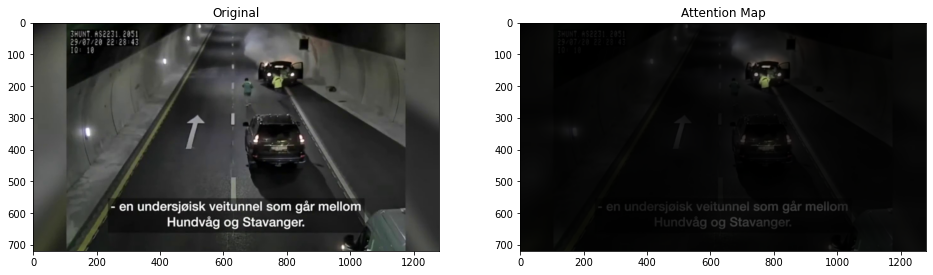

In [197]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
# for idx in top5[0, :5]:
#     print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

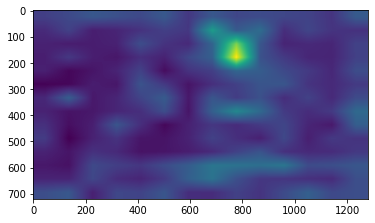

In [199]:
plt.imshow(mask)

In [200]:
r

[{'fire': 0.13590799272060394,
  'smoke': 0.8958907723426819,
  'spark': 0.07619757205247879}]

In [86]:
a = ['fire', 'spark', 'smoke']

In [87]:
a.sort()
a

['fire', 'smoke', 'spark']